In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path 
import iraklis7_linrg.config as config
import iraklis7_linrg.plots as plots
import iraklis7_linrg.features as features
import iraklis7_linrg.dataset as dataset

2026-01-27 14:49:24.232 | INFO     | iraklis7_linrg.config:<module>:15 - PROJ_ROOT path is: /Users/iraklis/git/iraklis7_linrg


### Load the data

In [3]:
input_path: Path = config.RAW_DATA_DIR / config.DATASET
plot_path: Path = config.FIGURES_DIR / config.CLEANING_PLOT

data = config.read_data(input_path)
if data is None:
    raise ValueError("read_data failed - data is None")

### Data transformation

In [4]:
data_tr = dataset.transform_data(data, 300)
data_tr.head()   

,Κωδικός Συστήματος,Εμβαδόν,Όροφος,Σύνολο ορόφων,Ασανσέρ,Θέα,Έτος κατασκευής,Έτος ανακαίνισης,Τιμή,Αρχική Τιμή
0,18055522,130,1.0,4.0,1,1.0,1988.0,2022.0,245.0,NaN
1,17845458,104,2.0,NaN,1,1.0,1978.0,NaN,171.0,179.0
2,18396501,132,7.0,7.0,1,1.0,1976.0,2000.0,400.0,NaN
3,18652593,117,6.0,NaN,1,1.0,2024.0,NaN,370.0,NaN
4,18433163,105,5.0,7.0,1,1.0,1972.0,NaN,229.0,NaN


In [5]:
output_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC
config.write_data(output_path,data_tr)

### Feature Engineering

In [6]:
# Return true if floor is the last floor on the building
data_tr['Όροφος Ρετιρέ'] = data_tr.apply(lambda row: features.is_top_floor(row['Όροφος'], row['Σύνολο ορόφων']), axis=1) 
data_tr[['Όροφος Ρετιρέ', 'Όροφος', 'Σύνολο ορόφων']]

,Όροφος Ρετιρέ,Όροφος,Σύνολο ορόφων
0,0,1.0,4.0
1,0,2.0,NaN
2,1,7.0,7.0
3,0,6.0,NaN
4,0,5.0,7.0
...,...,...,...
116,0,2.0,2.0
117,0,2.0,NaN
118,0,6.0,NaN
119,0,6.0,NaN


In [7]:
# Returns a label based on the age of the property
data_tr['Ηλικία'] = data_tr['Έτος κατασκευής'].apply(features.calc_age)
data_tr[['Ηλικία', 'Έτος κατασκευής']].head()

,Ηλικία,Έτος κατασκευής
0,0,1988.0
1,-1,1978.0
2,-1,1976.0
3,1,2024.0
4,-1,1972.0


In [8]:
# Returns a label based on the condition of the property
data_tr['Κατάσταση'] = data_tr.apply(lambda row: features.get_condition(row['Έτος κατασκευής'], row['Έτος ανακαίνισης']), axis=1)
data_tr[['Κατάσταση', 'Έτος κατασκευής', 'Έτος ανακαίνισης']].head()

,Κατάσταση,Έτος κατασκευής,Έτος ανακαίνισης
0,1,1988.0,2022.0
1,-1,1978.0,NaN
2,-1,1976.0,2000.0
3,1,2024.0,NaN
4,-1,1972.0,NaN


In [9]:
# Return true if elevator exists and floor is third or higher
data_tr['Ασανσέρ από 3ο'] = data_tr.apply(lambda row: features.elevator_from_third(row['Όροφος'], row['Ασανσέρ']), axis=1) 
data_tr[['Ασανσέρ από 3ο', 'Όροφος', 'Ασανσέρ']].head()

,Ασανσέρ από 3ο,Όροφος,Ασανσέρ
0,0,1.0,1
1,0,2.0,1
2,1,7.0,1
3,1,6.0,1
4,1,5.0,1


### Normalize the data

In [10]:
features_norm = data_tr.drop(['Τιμή', 'Αρχική Τιμή'], axis=1)
features_norm = features.normalize_data(features_norm)
labels = data_tr['Τιμή']

print(features_norm.head())
print(labels.head())

print(f"Peak to Peak range by column in Normalized dataset\n{np.ptp(features_norm,axis=0)}")

   Κωδικός Συστήματος   Εμβαδόν    Όροφος  Σύνολο ορόφων   Ασανσέρ       Θέα  \
0           -0.173384  0.418097 -1.321908      -0.621846  0.377964  0.467323   
1           -0.421445 -0.778658 -0.846847            NaN  0.377964  0.467323   
2            0.229271  0.510156  1.528456       1.062320  0.377964  0.467323   
3            0.531686 -0.180281  1.053395            NaN  0.377964  0.467323   
4            0.272565 -0.732629  0.578335       1.062320  0.377964  0.467323   

   Έτος κατασκευής  Έτος ανακαίνισης  Όροφος Ρετιρέ    Ηλικία  Κατάσταση  \
0         0.240472          0.392934      -0.317675  0.742918   1.263260   
1        -0.226891               NaN      -0.317675 -0.628623  -0.827653   
2        -0.320363         -1.610072       3.147871 -0.628623  -0.827653   
3         1.922979               NaN      -0.317675  2.114458   1.263260   
4        -0.507309               NaN      -0.317675 -0.628623  -0.827653   

   Ασανσέρ από 3ο  
0       -1.268344  
1       -1.268344  
2 

### Save normalized dataset, features and labels

In [11]:
features_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC_FEATURES
labels_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC_LABELS
config.write_data(features_path,features_norm)
config.write_data(labels_path,labels)   

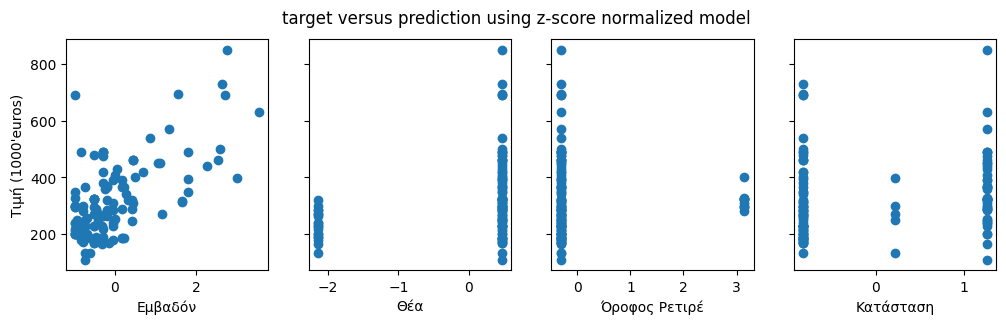

<Figure size 640x480 with 0 Axes>

In [12]:
features_sel = features_norm[['Εμβαδόν', 'Θέα', 'Όροφος Ρετιρέ', 'Κατάσταση', 'Ασανσέρ από 3ο']]
plots.gen(list(features_sel), features_sel.to_numpy(), labels, None, None, None, show=True, output_path=plot_path)